# Processing Images

Here we enhance the images (training and testing) to improve the image quality.

The processing steps:
1. Reads the input image
2. Converts from BGR to RGB
3. Resizes to specified dimensions (256x256) # we choose this for speed in training given we train in local machine, ideally we should use 512x512
4. Applies [CLAHE](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE) contrast enhancement (essential for retinal images) 
5. Saves the processed image


Define display images function

In [15]:
import os
import cv2
from matplotlib import pyplot as plt
def display_images(image_filenames:list[str], title="Image DataSet", col_count = 10):
    plt.suptitle(title, fontsize=20)
    img_count = len(image_filenames)
    plt.figure(figsize=(15, 15))
    for i in range(1, img_count+1):
        plt.subplot(5, col_count, i)
        image_path=image_filenames[i-1]
        image_name=os.path.basename(image_path)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, aspect="auto")
        plt.title(f"{image_name}")
        plt.axis(False)
    plt.show();

Define our image processor class

In [16]:
import cv2
import numpy as np
from pathlib import Path

class ODIRImageProcessor:
    """Simple processor for ODIR retinal images"""
    
    def __init__(self, output_size=512):
        self.output_size = output_size
    
    def process(self, input_path, output_path=None):
        """
        Process a single ODIR image
        
        Args:
            input_path: Path to input image
            output_path: Optional path to save result. If None, returns image array
        
        Returns:
            Processed image as numpy array
        """
        # Read image
        img = cv2.imread(str(input_path))
        if img is None:
            raise ValueError(f"Cannot read image: {input_path}")
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize
        img = cv2.resize(img, (self.output_size, self.output_size), 
                        interpolation=cv2.INTER_CUBIC)
        
        # Apply CLAHE for contrast enhancement
        img = self.apply_clahe(img)
        
        # Convert back to BGR for saving/display
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        # Save if output path is provided
        if output_path:
            cv2.imwrite(str(output_path), img_bgr)
            print(f"Saved processed image to: {output_path}")
        
       # return img_bgr
    
    def apply_clahe(self, image):
        """Apply CLAHE contrast enhancement"""
        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l_channel, a, b = cv2.split(lab)
        
        # Apply CLAHE to L-channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_channel = clahe.apply(l_channel)
        
        # Merge back
        lab = cv2.merge([l_channel, a, b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    def process_folder(self, input_folder, output_folder, extension=".jpg"):
        """
        Process all images in a folder
        """
        input_folder = Path(input_folder)
        output_folder = Path(output_folder)
        output_folder.mkdir(parents=True, exist_ok=True)
        
        image_files = list(input_folder.glob(f"*{extension}"))
        print(f"Found {len(image_files)} images to process")
        
        for img_path in image_files:
            output_path = output_folder / img_path.name
            try:
                self.process(img_path, output_path)
            except Exception as e:
                print(f"Error processing {img_path.name}: {e}")

# Initialize processor
#processor = ODIRImageProcessor(output_size=512)

# Process single image
#processor.process(
#    input_path="path/to/your/image.jpg",
#    output_path="path/to/save/processed_image.jpg"
#)

# OR process entire folder
# processor.process_folder(
#     input_folder="path/to/images",
#     output_folder="path/to/processed_images"
# )

Test on 1 image

In [17]:
import os
input_folder="ODIR-2019/preprocessed_images"
output_folder="ODIR-2019/processed_images"
input_image=f"{input_folder}/0_right.jpg"
output_image=f"{output_folder}/0_right.jpg"
os.makedirs(output_folder, exist_ok=True)
processor = ODIRImageProcessor(output_size=256)
processor.process(input_image, output_image)


Saved processed image to: ODIR-2019/processed_images/0_right.jpg


Display and compare

<Figure size 640x480 with 0 Axes>

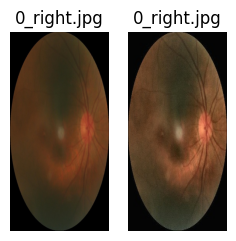

In [18]:
images=[input_image, output_image]
display_images(images);

We can see from above that our image processing enhance the detail of the image and make the vein more visible.

CLAHE algorithm makes the contrast better and now the image is clearer

Let's do it for all the other images

In [19]:
processor.process_folder(input_folder, output_folder)

Found 6392 images to process
Saved processed image to: ODIR-2019/processed_images/2342_left.jpg
Saved processed image to: ODIR-2019/processed_images/4227_right.jpg
Saved processed image to: ODIR-2019/processed_images/2124_left.jpg
Saved processed image to: ODIR-2019/processed_images/1402_right.jpg
Saved processed image to: ODIR-2019/processed_images/201_right.jpg
Saved processed image to: ODIR-2019/processed_images/2125_left.jpg
Saved processed image to: ODIR-2019/processed_images/1919_right.jpg
Saved processed image to: ODIR-2019/processed_images/4011_right.jpg
Saved processed image to: ODIR-2019/processed_images/3407_right.jpg
Saved processed image to: ODIR-2019/processed_images/260_left.jpg
Saved processed image to: ODIR-2019/processed_images/2343_left.jpg
Saved processed image to: ODIR-2019/processed_images/4682_right.jpg
Saved processed image to: ODIR-2019/processed_images/4361_right.jpg
Saved processed image to: ODIR-2019/processed_images/3294_right.jpg
Saved processed image to: 

In [20]:
import os
import cv2
import pandas as pd
import math

def sample_images(train_data, sample_count):
    return train_data.groupby('class').apply(lambda x: x.sample(sample_count)).reset_index(drop=True)

def view_random_images(samples, data_set_img_folder, title):
    images_path = list(samples['filename'])
    labels = list(samples['class'])
    samples_count = len(samples)
    class_count=8
    num_rows=math.ceil(samples_count/class_count)
    plt.figure(figsize=(class_count*2, num_rows*2))
    plt.suptitle(title, fontsize=14)
    for i in range(1, samples_count+1):
        plt.subplot(num_rows,class_count , i)
        image_path=os.path.join(data_set_img_folder, images_path[i-1])
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, aspect="auto")
        plt.title(f"{labels[i-1]}-{images_path[i-1].split('/')[-1]}", fontsize=8)
        plt.axis(False);
    plt.show()
result_datapath="ODIR-2019/results"
train_df = pd.read_csv(os.path.join(result_datapath, '01_eda_train_df.csv'))
samples = sample_images(train_df, 2)
samples
#view_random_images(train_df, input_folder, "Before Processing")
#view_random_images(train_df, output_folder, "After Processing")

/var/folders/pq/ctzkfdzj3cg4894zy28yqknc0000gn/T/ipykernel_31839/2160839873.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return train_data.groupby('class').apply(lambda x: x.sample(sample_count)).reset_index(drop=True)


,filename,ID,class,keywords,label
0,910_left.jpg,910,Ageing,dry age-related macular degeneration,A
1,775_right.jpg,775,Ageing,dry age-related macular degeneration diabetic ...,A
2,2146_right.jpg,2146,Cataract,cataract,C
3,2163_left.jpg,2163,Cataract,cataract,C
4,4296_left.jpg,4296,Diabetes,moderate non proliferative retinopathy,D
5,4522_right.jpg,4522,Diabetes,severe nonproliferative retinopathy,D
6,1288_left.jpg,1288,Glaucoma,glaucoma,G
7,1477_right.jpg,1477,Glaucoma,glaucoma,G
8,759_left.jpg,759,Hypertension,hypertensive retinopathy,H
9,783_right.jpg,783,Hypertension,hypertensive retinopathy moderate non prolifer...,H


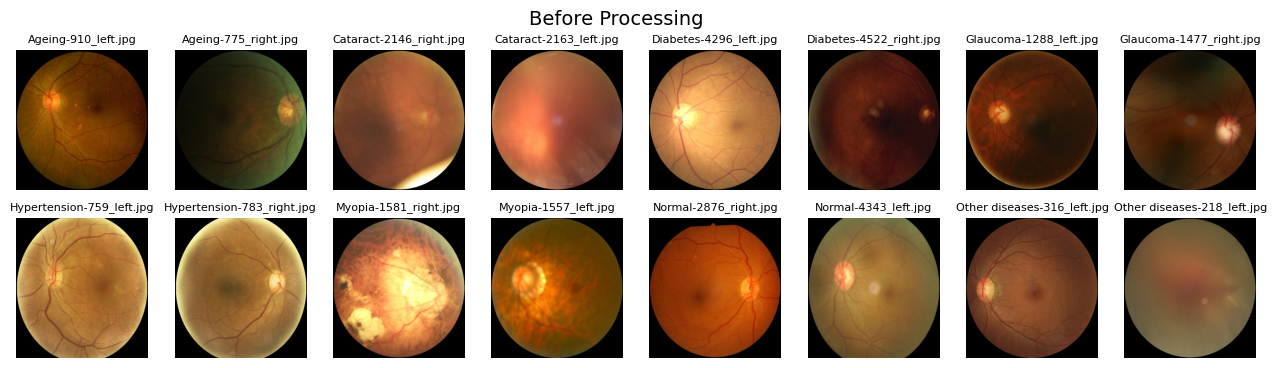

In [21]:
view_random_images(samples, input_folder, "Before Processing")

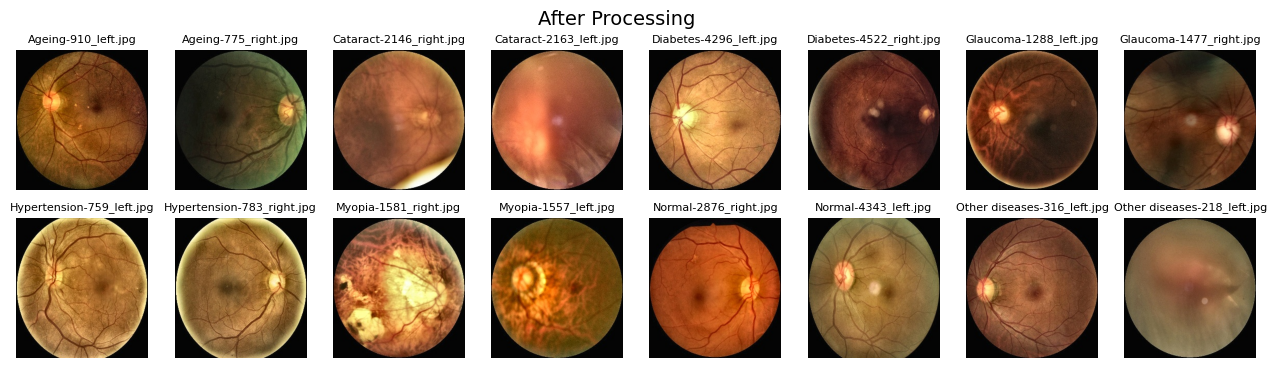

In [22]:
view_random_images(samples, output_folder, "After Processing")